In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display 
import itertools
from IPython.display import display
import random
import operator
from random import choices, randint, randrange, random, sample, seed, uniform, choice
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial
sns.set()
import random
from itertools import product
import re
from collections import OrderedDict
from operator import getitem
from pprint import pprint
from numpy import asarray
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import sys

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class MarketConfig: 
    #class attributes
    t0 = 2018 #The starting year for evaluation of the pay-offs
    T = 25  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2018, 2018 + T)
    distance = np.array([23000]) #nautical miles #Doudnikoff & Lacoste(2014). 
    port_time =  np.array([240]) #hours ==> 10 days in a year  #Doudnikoff & Lacoste(2014).
    demand_18_21 = np.array([7000000,7200000,7200000,7800000]) #2018-2021 TEU data for europe asia based on unctad 2020in TEU 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([822])  ## in US$/TEU 
    #SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    #SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter,
                 demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        #self.market_capacity = 0 #don 't need anymore
         
    
    #Don t need anymore
    #def get_market_capacity (self, firm_instance):
        #self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        #return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        #should be equal to 1, since we re keeping freight rate cst 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('real_growth_rate.csv') #import IMF data
        
        #-------> 2.Construct GDP projection path 2022-2043 based on projection growth data 
        gdp_growth= G_df.values[:,7:28] #Read gdp growth from 2022-2,043; file begins with 2016 growth rates
        g =1 +(gdp_growth/100)  
        #self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        #for foo in range (1,MarketConfig.T):
        #    self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
            
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([np.float64(g[:,0]) for j in range(np.size(g))])
        for moo in range (np.size(g)):
            sub_g = g[:,:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)  
    
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        predict_demand= np.multiply(loo, MarketConfig.demand_18_21[3])
        self.planing_market_demand = np.concatenate((MarketConfig.demand_18_21, predict_demand), axis=None) #concatenate the predicted values with the Untac data        
        self.market_demand = self.planing_market_demand[:MarketConfig.T]
        #print(Y) # size = 1 dimesion array with size T=35 years
        #self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_18_21[3] )
        return self.market_demand #, self.gdp #, self.market_psy

In [5]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type, SFOC_M, SFOC_A, market_share):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        #self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        self.SFOC_M = SFOC_M
        self.SFOC_A = SFOC_A
        self.market_share = market_share # the firm's market share 
        #self.bau_emission = bau_emission
         
   
    # Firm methods # Reupdate to make market share as in input
    #def get_market_share(self , market_instance):
        #'''return market share of the firm accoding to it s capacity'''
        #self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        #self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        #return self.market_share
        
    #def get_firm_param(self, market_instance):
        #self.psy = np.multiply (self.market_share , market_instance.market_psy)
        #return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        #print("firme demand", self.firm_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        #print(self.operational_speed)
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed) #returns a vector 
        #print( " operational_speed", self.operational_speed)
        #print( " self.time_at_sea", self.time_at_sea)
        self.voyage_time = self.time_at_sea + market_instance.port_time #returns a vector 
        self.number_of_trips_to_meet_demand = np.ceil(np.true_divide(self.firm_demand, self.capacity)) #returns a vector
        self.max_trips_per_vessel = np.floor(np.true_divide(market_instance.annual_working_time, self.voyage_time)) #returns a vector
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel) #returns a vector
        #print("max_trips_per_vessel", self.number_of_trips_to_meet_demand)
        #print("min_number_of_vessel_to_meet_demand", self.min_number_of_vessel_to_meet_demand)
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand) #returns a vector
        #print("self.number_of_vessel", self.number_of_vessel)
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        '''ship effici = SFPC * ENGINE POWER * ENGINE LOAD)* (Vds)^-3 '''
        self.main_fuel_parameter = self.SFOC_M * market_instance.eng_load_main * self.main_engine_power * 10**(-6)#self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(self.SFOC_M, market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )  
        #print("self.ship_energy", self.ship_energy)
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        ''' fuel consu = ship eff * d * V^2 * # of trips to meet demand'''
        self.moo_1 = np.multiply(market_instance.distance, self.ship_energy)
        self.moo_2 = np.power(self.operational_speed, 2)
        self.moo_3 = np.multiply(self.moo_1, self.moo_2)
        self.main_fuel_cons = np.multiply(self.moo_3 , self.number_of_trips_to_meet_demand)
        #print("self.main_fuel_cons ", self.main_fuel_cons )
        return self.main_fuel_cons #returns a vector
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( self.SFOC_A, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6)) #self.aux_fuel_parameter = self.SFOC_A * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        #print("self.aux_fuel_cons",self.aux_fuel_cons)
        return self.aux_fuel_cons #returns a vector   
    
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        #print("self.fuel_cost", self.fuel_cost)
        return self.fuel_cost #returns a vector
    
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self.carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  
        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self.carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  
        self.carbon_emissions = self.carbon_main_emissions + self.carbon_aux_emissions 
        #print("self.carbon_emissions", self.carbon_emissions )
        return self.carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self.sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  
        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self.sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  
        self.sulfur_emissions = self.sulfur_main_emissions + self.sulfur_aux_emissions 
        #print("self.sulfur_emissions", self.sulfur_emissions)
        return self.sulfur_emissions      
    
            
    def get_total_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        #print("self.total_cost", self.total_cost)
        return self.total_cost #returns a vector    
     
                 
    def get_revenue(self,market_instance):
        self.revenue = np.multiply(self.firm_demand, market_instance.freight_rate)
        #print("self.revenue", self.revenue)
        return self.revenue #returns a vector
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        #print("self.period_profit", self.period_profit)
        return self.period_profit #returns a vector

# Inilize firm and market parmeters

In [6]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([14000]) 
#max_number_of_vessel_1= np.array([100]) 
design_speed_1 = np.array([25.0]) #design speed of the vessel isn knots
min_speed_1 = 12.0
max_speed_1 = 28.0
main_engine_power_1 =np.array([89700])  # main engine power in kW
aux_engine_power_1 =np.array([14000])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([50000*365])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "ULSFO"
SFOC_M_1 = 175
SFOC_A_1 = 32
market_share_1 = 0.5 #UPDATE Firm 1's market share 
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([8000])
#max_number_of_vessel_2 = np.array([100])
design_speed_2 = np.array([25.0])  #design speed of the vessel in knots
min_speed_2 = 12.0
max_speed_2 = 28.0
main_engine_power_2 = np.array([68500]) # main engine power in kW
aux_engine_power_2 =np.array([12000])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([37618*365]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "ULSFO"
SFOC_M_2 = 133
SFOC_A_2 = 24
market_share_2 = 0.3 #UPDATE Firm 2's market share 
                    #===========================>  Firm 3 Attributes <==========================#
index_3 = 3
capacity_3 = np.array([6000])
#max_number_of_vessel_3 = np.array([100])
design_speed_3 = np.array([25.0])  #design speed of the vessel in knots
min_speed_3 = 12.0
max_speed_3 = 28.0
main_engine_power_3 = np.array([57100]) # main engine power in kW
aux_engine_power_3 =np.array([12900])   # auxiliary engine power [kW] 
fix_cost_3 =np.array([33466*365]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_3 = "ULSFO"
SFOC_M_3 = 114
SFOC_A_3 = 26
market_share_3 = 0.2 #UPDATE Firm 3's market share 
                    #===========================> Market Attributes <==========================#
number_of_firms = 3
pollution_decay_parameter =  np.array([1])
pollution_damage_parameter =  np.array([1.5])
year  = MarketConfig.year
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([822]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# Create simulation Objects

In [7]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1, SFOC_M_1, SFOC_A_1, market_share_1) 

firm_2 = Firm(index_2, capacity_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2, SFOC_M_2, SFOC_A_2, market_share_2) 

firm_3 = Firm(index_3, capacity_3,  design_speed_3, 
                 min_speed_3, max_speed_3, main_engine_power_3, aux_engine_power_3,
                 fix_cost_3, fuel_type_3,SFOC_M_3, SFOC_A_3, market_share_3) 

game_config = MarketConfig(number_of_firms, pollution_decay_parameter, pollution_damage_parameter, 
                           income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
#for  firm_object in Firm._registry:
#    market_capacity_sim = game_config.get_market_capacity(firm_object)

# Market Demand

In [8]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
#market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
market_demand_sim = game_config.get_market_demand()
#print("market demand", market_demand_sim)

# Get each firm's  market share  
#firm_1_market_share_sim = firm_1.get_market_share(game_config)
#print("firm 1 market share", firm_1_market_share_sim)

#firm_2_market_share_sim = firm_2.get_market_share(game_config)
#print("firm 2 market share", firm_2_market_share_sim)

#firm_3_market_share_sim = firm_3.get_market_share(game_config)
#print("firm 3 market share", firm_3_market_share_sim)

#======> Plotting BAU GDP,2016=100
#sns.set()
#ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
#ax.set(xlabel='year', ylabel='GDP')
#plt.title("BAU GDP,2016=100" )
#plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
#ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
#ax.set(xlabel='year', ylabel='transport work in TEU')
#plt.title("market demand in TEU " )
#plt.show()

#======> Plotting Marketshare per firm
## This graph needs tobe updatedtoinclude GDP growth rates and split the demand and predicted demand


# Firms: Firm 1

In [9]:
 # 7.Get firm passthrough parameter
#firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
#print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
#print("firm 1 ship energy", firm_1_ship_energy_sim)
#======> Plotting The firm's 
#ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
#ax.set(xlabel='year', ylabel='transport work in TEU')
#plt.title("firm 1 level demand in TEU " )
#plt.show()


# Firms: Firm 2

In [10]:
# 7.Get firm passthrough parameter
#firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
#print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
#print("firm 2 ship energy", firm_2_ship_energy_sim)
#======> Plotting The firm's 
#ax=sns.lineplot(x=year ,y = firm_2_demand_sim , color = 'green')
#ax.set(xlabel='year', ylabel='transport work in TEU')
#plt.title("firm 2 level demand in TEU " )
#plt.show()

# Firms: Firm 3

In [11]:
# 7.Get firm passthrough parameter
#firm_3_psy_sim = firm_3.get_firm_param(game_config)

# 7.Get firm level demand  
firm_3_demand_sim = firm_3.get_firm_demand(game_config)
#print("firm 3 demand", firm_3_demand_sim)


# 9.Get ship energy efficiency  
firm_3_ship_energy_sim = firm_3.get_ship_energy_efficiency(game_config)
#print("firm 3 ship energy", firm_3_ship_energy_sim)
#======> Plotting The firm's 
#ax=sns.lineplot(x=year ,y = firm_3_demand_sim , color = 'green')
#ax.set(xlabel='year', ylabel='transport work in TEU')
#plt.title("firm 3 level demand in TEU " )
#plt.show()

# A fine grained PGA (parallel genetic algorithm)

In [12]:
#====> Iinitialisation of chromo and population objects 
Chromo =  float
Population = List[Chromo]
#====> Iinitialisation of function objects; Define the Objects; They allow you to pass in only what you need during the evol function 
PopulateFunc = Callable[[], Population]
VesselProc = Callable[[Chromo, Firm], Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray , np.ndarray ,np.ndarray, np.ndarray, np.ndarray]]
Best_Partner_And_Fitness_Func = Callable[[Chromo,int, int, Firm, dict] , dict]  
Integrated_Solution_Combo_Func = Callable[[dict, list , np.ndarray, np.ndarray,] , dict]

SelectionFunc = Callable[[np.ndarray, np.ndarray], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one
FitnessFunc = Callable[[Chromo], list] #int to refelct max # of vessel



### 1) GA specific functions 

In [13]:
#======> Generate Chromo
def generate_chromo(firm: Firm, vessel_proc: VesselProc) :
    '''generate the chromos, ie, each firm s vessel speed in the planing horizon based on speed constraint; [v1,..,vt]'''
    #while True:
    chromo = np.random.uniform(firm.min_speed, firm.max_speed)  
        #if (vessel_proc(chromo, firm)[0] != 0).all():
            #break
        #print("chromo", chromo)
    return chromo  

#======> Generate Population
def generate_population(vessel_proc: VesselProc, firm:Firm, size: int ):
    '''generate the population of the firm s vessel speed based on our coev choice param population size'''
    return  np.array([generate_chromo(firm, vessel_proc) for _ in range(size)])

#=====> Select Parent Chromo 
def selection_pair (chromo, weights): 
    '''randomly select 2 chromo from the population based on their weights, ie , solution fitness''' 
    #print(chromo)
    #print(weights)
    weights = np.asarray(weights).astype('float64')
    weights = weights / np.sum(weights)
    selected_index = np.random.choice(np.arange(9),size = 2, replace=False,p= weights)
    #print("chromo[selected_index[0]]", chromo[selected_index[0]])
    #print("chromo[selected_index[1]", chromo[selected_index[1]])
    return chromo[selected_index[0]],chromo[selected_index[1]]

#=======> Child Chromo based on parent chrossover
def BLX_alpha_crossover (a: Chromo, b: Chromo, firm :Firm, sim_game) :
    #child = np.zeros(sim_game.T)
    #lower = np.zeros(sim_game.T)
    #upper = np.zeros(sim_game.T)
    #for i in range(sim_game.T): 
    lower = (min(a,b)) - ( (0.5) * (max(a,b) - min (a,b)))
    upper= (max(a,b)) + ( (0.5) * (max(a,b) - min (a,b)))
    lower= firm.min_speed if (lower < firm.min_speed) else lower
    upper= firm.max_speed if (upper > firm.max_speed) else upper
    child = np.random.uniform (lower, upper)
    #print("child", child)
    
    return child

#=====>#mutation prob = 0.5
def mutation(chromo: Chromo, firm: Firm, sim_game, variance: float, probability: float = 0.1 ) : 
    #mutated_chromo = np.zeros(sim_game.T)
    #print("chromo",chromo)
    #for i in range(sim_game.T): 
    mutated_chromo = np.random.normal(chromo, variance, 1) if random.random() > probability else chromo
    #print("mutated_chromo ",mutated_chromo[i])
    mutated_chromo = firm.min_speed  if mutated_chromo < firm.min_speed  else mutated_chromo
    mutated_chromo = firm.max_speed if mutated_chromo  > firm.max_speed else mutated_chromo
    #print("mutated_chromo", mutated_chromo)
    return mutated_chromo
#====> 
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result

### 2. Vessel Operations and Fitness Evaluation

In [14]:
def vessel_operation_procedure (chromo: Chromo, firm: Firm, sim_game: MarketConfig): 
    
    operational_speed_ = np.repeat (firm.update_vessel_speed(chromo),sim_game.T) # firm.update_vessel_speed(chromo)
    #print("operational_speed", operational_speed_)
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game)
    #print(min_number_vessels_sim, trips_to_meet_demand_sim, time_at_sea_sim )
    number_vessels_sim  = firm.get_number_of_vessel()
    #print("number_vessels_sim", number_vessels_sim)
    
    #if (number_vessels_sim > firm.max_number_of_vessel).any():
        #true 
        #return np.zeros(9) #np.array([0,..,0])
    #else:
    main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)
    #print("main_fuel_con_sim", main_fuel_con_sim)
    aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
    #print("aux_fuel_con_sim", aux_fuel_con_sim)
    fuel_cost_sim = firm.get_fuel_cost(sim_game) 
    #print("fuel_cost_sim", fuel_cost_sim)
    total_cost_sim = firm.get_total_cost()
    #print("total_cost_sim", total_cost_sim)
    revenue_sim = firm.get_revenue(sim_game)
    #print("revenue_sim", revenue_sim)
    profit_vector_sim = firm.get_period_profits()
    #print("profit_vector_sim", profit_vector_sim)
                        
    carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game) 
    #print("carbon_emissions_sim", carbon_emissions_sim)
    sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
    #print("sulfur_emissions_sim", sulfur_emissions_sim)
    return number_vessels_sim, main_fuel_con_sim, aux_fuel_con_sim, fuel_cost_sim, total_cost_sim , revenue_sim ,profit_vector_sim, carbon_emissions_sim, sulfur_emissions_sim

In [15]:
# objective function
def fitness(vessel_proc : VesselProc, 
            chromo_array, 
            sim_game,           
            carbon_pollution_decay_parameter,
            sulfur_pollution_decay_parameter,
            carbon_pollution_damage_parameter,
            sulfur_pollution_damage_parameter,
            initial_carbon_tax_sim,
            initial_sulfur_tax_sim,
            taxation_scheme_rate_sim):
    """get 3 chromos and returns payoffs"""
    # discount rate
    discount_multiplier = np.power( 1+ sim_game.discount_rate, - np.arange(1,MarketConfig.T + 1))
    
    # vessel speed operations
    operations = [vessel_proc (chromo_array[firm.index -1 ], firm) for  firm in  Firm._registry ] 
    profits =  [operations[firm.index -1 ][6] for  firm in  Firm._registry ] 
    carbon_emissions =   [operations[firm.index -1 ][7] for  firm in  Firm._registry ] 
    #print("carbon_emissions",carbon_emissions)
    sulfur_emissions =   [operations[firm.index -1 ][8] for  firm in  Firm._registry ]   
    #print("sulfur_emissions", sulfur_emissions)
    
    #Indutry level 
    industry_carbon_emission = (np.sum(carbon_emissions, axis = 0)).reshape(-1)
    industry_sulfur_emission = (np.sum(sulfur_emissions, axis = 0)).reshape(-1)
    #print ("industry_carbon_emission", industry_carbon_emission)
    #print ("industry_sulfur_emission", industry_sulfur_emission)
        
    #pollution stock 
    carbon_pollution_stock=np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T
    sulfur_pollution_stock= np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T
    
    for my_period_index in range (MarketConfig.T-1):
        carbon_pollution_stock [my_period_index + 1] = (1- carbon_pollution_decay_parameter ) * carbon_pollution_stock[my_period_index ] + industry_carbon_emission[my_period_index]
        sulfur_pollution_stock [my_period_index + 1] = (1- sulfur_pollution_decay_parameter ) * sulfur_pollution_stock[my_period_index ] + industry_sulfur_emission[my_period_index]
    
    #print("carbon_pollution_stock", carbon_pollution_stock)
    #print("sulfur_pollution_stock", sulfur_pollution_stock)
    
    #dynamic tax
    carbon_dynamic_tax = np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T 
    sulfur_dynamic_tax = np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T
    
    carbon_dynamic_tax[0] = initial_carbon_tax_sim
    sulfur_dynamic_tax[0] = initial_sulfur_tax_sim
    for my_period_index in range (MarketConfig.T-1):
        carbon_dynamic_tax[my_period_index+1] = initial_carbon_tax_sim + (taxation_scheme_rate_sim * carbon_pollution_stock[my_period_index +1 ])
        sulfur_dynamic_tax[my_period_index+1] = initial_sulfur_tax_sim + (taxation_scheme_rate_sim * sulfur_pollution_stock[my_period_index +1 ])

    
    #print("carbon_dynamic_tax", carbon_dynamic_tax)
    #print("sulfur_dynamic_tax", sulfur_dynamic_tax)
    
    #### Get the industry s damages 
    industry_carbon_damages = 0.5* carbon_pollution_damage_parameter * np.power( carbon_pollution_stock,2)
    industry_sulfur_damages = 0.5* sulfur_pollution_damage_parameter * np.power( sulfur_pollution_stock,2)
 
    #print("industry_carbon_damages", industry_carbon_damages)
    #print("industry_sulfur_damages", industry_sulfur_damages)
    
    
    
    
    #### Get Abatement benefits 
    abatement_benefits =   BAU_carbon_damages - industry_carbon_damages
    
    
    ### Get NPV for each firm 
        #print("tac", carbon_dynamic_tax )
        #print("carbon_emissions_sim ]", carbon_emissions_sim["firm" + str (firm.index)])
        #print ("check",  carbon_emissions_sim["firm" + str (firm.index)] * carbon_dynamic_tax )
    
    
    
    abatement_benefits_firm = [np.multiply( abatement_benefits ,  firm.market_share  ) for firm in Firm._registry ] 

    carbon_policy_cost = [np.multiply(carbon_emissions[firm.index - 1]  , carbon_dynamic_tax ) for firm in Firm._registry ] 
    #print("carbon_policy_cost",carbon_policy_cost)
    sulfur_policy_cost = [np.multiply(sulfur_emissions[firm.index - 1]  , sulfur_dynamic_tax ) for firm in Firm._registry ]
    #print("sulfur_policy_cost",sulfur_policy_cost)
    policy_cost = [carbon_policy_cost[firm.index - 1] + sulfur_policy_cost[firm.index - 1] for firm in Firm._registry ] 
    
    
    
    #print("policy_cost",policy_cost)
    period_profit_witout_benefits = [profits[firm.index - 1]  -  policy_cost[firm.index - 1] for firm in Firm._registry ]  
    
    period_profit = [period_profit_witout_benefits[firm.index - 1]  +  abatement_benefits_firm[firm.index - 1] for firm in Firm._registry ]  

    #print("period_profit", period_profit)
    discounted_period_profit = [np.multiply( discount_multiplier, period_profit[firm.index - 1]) for firm in Firm._registry]
    #print("discounted_period_profit", discounted_period_profit)
    
    payoff=[np.sum(discounted_period_profit[firm.index - 1]) for firm in Firm._registry] 
    #print("payoff", payoff)
    return payoff, discounted_period_profit, period_profit, policy_cost, sulfur_policy_cost, carbon_policy_cost, industry_sulfur_damages, industry_carbon_damages, sulfur_emissions, carbon_emissions, industry_carbon_emission,industry_sulfur_emission,carbon_pollution_stock, sulfur_pollution_stock,carbon_dynamic_tax,sulfur_dynamic_tax,  operations 

In [16]:
def best_partner_selection_and_fitness_evaluation (vessel_proc : VesselProc, 
                                                   selected_chromo, 
                                                   selected_chromo_row_loc,
                                                   selected_chromo_column_loc, 
                                                   evolving_species, 
                                                   symbiotic_species, 
                                                   symbiotic_population,
                                                   sim_game, 
                                                   pop_grid_reshape_size,
                                                   carbon_pollution_decay_parameter,
                                                   sulfur_pollution_decay_parameter,
                                                   carbon_pollution_damage_parameter,
                                                   sulfur_pollution_damage_parameter,
                                                   initial_carbon_tax_sim ,
                                                   initial_sulfur_tax_sim ,
                                                   taxation_scheme_rate_sim) :


    #==========================================================================================================#
    ############################################ 0. Initilasiation ###########################################
    #==========================================================================================================#
    discount_multiplier = np.power( 1+ sim_game.discount_rate, - np.arange(1,MarketConfig.T + 1))
    #print(discount_multiplier)
    
    def getNPV(elem):
        return elem["NPV"]

    #==========================================================================================================#
    #### 1. Get operational results for the chromo to be evaluated of the respective firm  #############
    #==========================================================================================================#
    evolving_firm_vessel_operations = vessel_proc (selected_chromo,evolving_species)

     #==========================================================================================================#
    ########################################### 2. Symbiotic Spiecies   #######################################
    #==========================================================================================================#
    carbon_emissions_sim = {}
    sulfur_emissions_sim = {}
    symbiotic_neighberhood ={}
    candidate_partner_chromo = {}
    for _ in (symbiotic_species):
#========================> 2.1. Get Symbiotic Population in toroidal grid format <====================================#
        firm_symbiotic_pop = symbiotic_population["firm" + str(_.index)].reshape(pop_grid_reshape_size,
                                                                                 pop_grid_reshape_size)
                                                                                 #MarketConfig.T)
        #print("firm_symbiotic_pop shaped to toroidal gris", firm_symbiotic_pop)
    
#===============> 2.2. Get Symbiotic Neighberhood range based on inital pt of evoluaion coordinatest <====================================#
        # A  structure of 3 × 3 neighborhood is used for the localized coevolutio
        neighberhood_row_selection_range = range(selected_chromo_row_loc - 1, selected_chromo_row_loc + 2 )
        neighberhood_column_selection_range = range(selected_chromo_column_loc - 1, selected_chromo_column_loc + 2 )
        #print("neighberhood_selection_range : ", neighberhood_row_selection_range, neighberhood_column_selection_range)
        
#========================> 2.3. Set Up the neighberhood for  Symbiotic Spiecies <====================================#
        # the neighborhood includs individual (m,n) and its eight neighbors in the sympioses  firm  pop
        # these are candidate partners for the fitness evaluation
        symbiotic_neighberhood= firm_symbiotic_pop.take(neighberhood_row_selection_range,
                                                        mode='wrap',
                                                        axis = 0).take(neighberhood_column_selection_range,
                                                                       mode='wrap',
                                                                       axis=1) 
        #print("symbiotic_neighberhood is ", symbiotic_neighberhood)
        
#========================>2.4. Get the 9 candidate partners for the fitness evaluaion [] <====================================#
        #reshape the neighberhood into 9 partner candidiate, A dict of the selected candidate partner chromos; 9 chromos for each firm 
        #candidate_partner_chromo["firm2":[.,.,.,] ,"firm3":[.,.,.,] ]
        candidate_partner_chromo["firm" + str(_.index)] = np.reshape(symbiotic_neighberhood, (9,1))
                                                                     #, (9, MarketConfig.T )) #(l*m, n)
        #print("candidate_partner_chromo", _, candidate_partner_chromo)
        
#========================> 2.4. Get the 9 candidate partners for the fitness evaluaion [] <====================================#
        #Get candidate partner (symbiotic firms) period emission level based on their chromo
        carbon_emissions_sim["firm" + str(_.index)] ={}
        sulfur_emissions_sim["firm" + str(_.index)] = {}
        for partner_chromo_candidate_index in range(9):
            symbiotic_firm_vessel_operations = vessel_proc (candidate_partner_chromo["firm" + str(_.index)][partner_chromo_candidate_index], _)
            carbon_emissions_sim["firm" + str(_.index)] ["_chromo" + str(partner_chromo_candidate_index)] =  symbiotic_firm_vessel_operations[7] 
            sulfur_emissions_sim["firm" + str(_.index)] ["_chromo" + str(partner_chromo_candidate_index)] =  symbiotic_firm_vessel_operations[8]
            #print("carbon_emissions_sim for each firm", carbon_emissions_sim)
    
    #carbon_emissions_sim:{{firm2 :{chromo0 :[.,.,.,],...,  chromo8:[.,.,.,]} ,
    #                       firm3: {chromo0 :[.,.,.,],...,  chromo8:[.,.,.,]}} 
    
    #print("carbon_emissions_sim full dict", carbon_emissions_sim)
    #print("done boucle 1 ")
    #==========================================================================================================#
    ############################## 3.. Industry Level Pollution Computation    #################################
    #==========================================================================================================#
#========================================> 3.1.Create Combos <====================================#
    #Intilise the following dict for the evolving firm (ex : evolvin firm : firm 1) :
    #industry_carbon_emission_combo [{'firm2': '_chromo0'}, {'firm2': '_chromo1'}, 
    #{'firm2': '_chromo2'}, {'firm2': '_chromo3'}, {'firm2': '_chromo4'}, {'firm2': '_chromo5'}, 
    #{'firm2': '_chromo6'}, {'firm2': '_chromo7'}, {'firm2': '_chromo8'}]

    industry_carbon_emission_combo = [dict(zip(carbon_emissions_sim.keys(), a)) for a in itertools.product(*carbon_emissions_sim.values())]
     #industry_carbon_emission_combo is a list of dicts 
    
    #Update the the dict with the right emission values 
    for carbonindex in range(len(industry_carbon_emission_combo)):
        for firm in industry_carbon_emission_combo[carbonindex].keys():
            industry_carbon_emission_combo[carbonindex].update({str(firm): {str(industry_carbon_emission_combo[carbonindex][str(firm)]): 
                                 carbon_emissions_sim[str(firm)][str(industry_carbon_emission_combo[carbonindex][str(firm)])]}})
    
    #print("partners chromos cobination of emissions", industry_carbon_emission_combo )
    #print("done boucle 2")
    
  #========================================> 3.2. Compute industry level emissions <====================================#  
    firms = tuple(industry_carbon_emission_combo[0].keys())
    #print("firms are", firms)

    #print("evolving_firm_vessel_operations[7]", evolving_firm_vessel_operations[7])
#     print("Initilised dict", industry_carbon_emission_combo)
#     print("done boucle 3")
    
    carbon_emission_array = []
    for myindex in range(len(industry_carbon_emission_combo)):
        industry_carbon_emission_combo[myindex]["industry_carbon_emission"] ={}
        for firm in firms:
            chromos, firm_carbon_emission = tuple(zip(*industry_carbon_emission_combo[myindex][str(firm)].items()))
            #print("chromos", chromos)
            #print("firm_carbon_emission", firm_carbon_emission)
            carbon_emission_array.append(industry_carbon_emission_combo[myindex].get(str(firm)).get(str(chromos[0])))
            #print("carbon_emission_array",carbon_emission_array)
        industry_carbon_emission_combo[myindex]["industry_carbon_emission"] = evolving_firm_vessel_operations[7] + np.sum(carbon_emission_array, axis = 0) 
        
        carbon_emission_array =[]
    
    #print("industry level emissiom ; pollution sum ",industry_carbon_emission_combo)
    #print("done boucle 4")

#========================================> 3.2. Sulfur industry emissions <====================================#
    #get all possible combination
    industry_sulfur_emission_combo = [dict(zip(sulfur_emissions_sim.keys(), a)) for a in itertools.product(*sulfur_emissions_sim.values())]
    for sulfur_index in range(len(industry_sulfur_emission_combo)):
        for firm in industry_sulfur_emission_combo[sulfur_index].keys():
            industry_sulfur_emission_combo[sulfur_index].update({str(firm): {str(industry_sulfur_emission_combo[sulfur_index][str(firm)]): 
                                 sulfur_emissions_sim[str(firm)][str(industry_sulfur_emission_combo[sulfur_index][str(firm)])]}})

    
 #========================================> 3.2. Compute industry level emissions <====================================#  
    firms = tuple(industry_sulfur_emission_combo[0].keys())
    #print("industry_sulfur_emission_combo pre update",industry_sulfur_emission_combo)
    sulfur_emission_array = []
    for myindex in range(len(industry_sulfur_emission_combo)):
        industry_sulfur_emission_combo[myindex]["industry_sulfur_emission"] ={}
        for firm in firms:
            chromos, firm_sulfur_emission = tuple(zip(*industry_sulfur_emission_combo[myindex][str(firm)].items()))
            #print("chromos", chromos)
            #print("firm_sulfur_emission", firm_sulfur_emission)
            sulfur_emission_array.append(industry_sulfur_emission_combo[myindex].get(str(firm)).get(str(chromos[0])))
            #print("sulfur_emission_array",sulfur_emission_array)
        industry_sulfur_emission_combo[myindex]["industry_sulfur_emission"] = evolving_firm_vessel_operations[8] + np.sum(sulfur_emission_array, axis = 0) 
        sulfur_emission_array =[]
    
    #print("industry level emissiob",industry_sulfur_emission_combo)
    #print("done boucle 4")
    #==========================================================================================================#
    ##################################### 4. Policy Cost evaluation     #######################################
    #==========================================================================================================#
#===============================> 4.1. Carbon policy cost and pollution stock and damages <======================#
    #fitness of the chromo : 
 
    for  boo in range(len(industry_carbon_emission_combo)):
        industry_carbon_emission_combo[boo]["carbon_pollution_stock"] =np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[boo]["industry_carbon_damages"]= np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[boo]["carbon_dynamic_tax"]  = np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[boo]["carbon_dynamic_tax"][0]  = initial_carbon_tax_sim    
        
        for my_period_index in range (MarketConfig.T-1): 
             #Remove and multipy instead of using loop 
            industry_carbon_emission_combo[boo]["carbon_pollution_stock"] [my_period_index + 1] = (1- carbon_pollution_decay_parameter ) * industry_carbon_emission_combo[boo]["carbon_pollution_stock"][my_period_index ] + industry_carbon_emission_combo[boo]["industry_carbon_emission"][my_period_index]
            industry_carbon_emission_combo[boo]["carbon_dynamic_tax"] [my_period_index+1] = initial_carbon_tax_sim + (taxation_scheme_rate_sim * industry_carbon_emission_combo[boo]["carbon_pollution_stock"][my_period_index +1 ])

        industry_carbon_emission_combo[boo]["industry_carbon_damages"] = 0.5* carbon_pollution_damage_parameter * np.power( industry_carbon_emission_combo[boo]["carbon_pollution_stock"],2)
        industry_carbon_emission_combo[boo]["carbon_policy_cost"] = np.multiply(evolving_firm_vessel_operations[7], 
                                                                    industry_carbon_emission_combo[boo]["carbon_dynamic_tax"]) # a numpy vectore
 
    #print("industry_carbon_emission_combo after update", industry_carbon_emission_combo)
 
#===============================> 4.2. sulfur policy cost and pollution stock and damages <=====================#
    for loo in range(len(industry_sulfur_emission_combo)):
        industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"] =np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[loo]["industry_sulfur_damages"]= np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"]  = np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"][0]  = initial_sulfur_tax_sim
    
        for my_period_index in range (MarketConfig.T-1): 
            #Remove and multipy instead of using loop 
            industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"] [my_period_index + 1] = (1- sulfur_pollution_decay_parameter ) * industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"][my_period_index ] + industry_sulfur_emission_combo[loo]["industry_sulfur_emission"][my_period_index]
            industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"] [my_period_index+1] = initial_sulfur_tax_sim + (taxation_scheme_rate_sim * industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"][my_period_index +1 ])

        industry_sulfur_emission_combo[loo]["industry_sulfur_damages"] = 0.5* sulfur_pollution_damage_parameter * np.power( industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"],2)
        industry_sulfur_emission_combo[loo]["sulfur_policy_cost"] = np.multiply(evolving_firm_vessel_operations[8], 
                                                                    industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"]) # a numpy vectore

    #print("industry_sulfur_emission_combo after update initial", industry_sulfur_emission_combo)
    #==========================================================================================================#
    ##################################### 5.Evolving Firm Update      #######################################
    #==========================================================================================================#
#===============================> 4.1. Carbon policy cost and pollution stock and damages <======================#
    #substitue the emission array with the candiidate partner speed array value
    #Original dict : firm1: chromo0: emissions ====> New dict: firm1:chromo0: vessel speed 
    #Turn updated chromo into a key 
    for koo in range(len(industry_carbon_emission_combo)):
        for firm in firms:
            chromos, chromo_tobe_updated = zip(*industry_carbon_emission_combo[koo][str(firm)].items())
            industry_carbon_emission_combo[koo][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]
    
    #print("industry_carbon_emission_combo after  2 update: what is this ??", industry_carbon_emission_combo)
    
#===============================> 4.2. sulfur policy cost and pollution stock and damages <=====================#
    #Update chromo for sulfur
    for koo2 in range(len(industry_sulfur_emission_combo)):
        for firm in firms:
            chromos, chromo_tobe_updated = zip(*industry_sulfur_emission_combo[koo2][str(firm)].items())
            industry_sulfur_emission_combo[koo2][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]
   
    #print("industry_sulfur_emission_combo after  2 update", industry_sulfur_emission_combo)
     
    #==========================================================================================================#
    ##################################### 6. final resuls     #######################################
    #==========================================================================================================#
#================================================> 6.1. Combine dicts <========================================#
    #consolidate resuls into 1 dict : pollution analysis 
    pollution_analysis = [{**a, **b} for a, b in zip(industry_carbon_emission_combo, industry_sulfur_emission_combo)]
    #print("pollution analysis consolidation", pollution_analysis )
#=======================================> 6.2. add pollution and update  cost and revenues <=====================#
    #Update pollution analysis with remaining info 
    #tHERE IS A BUG HERE ; MUST UPDATE WITH KEYS 
    for koo3 in range(len(pollution_analysis)):
        pollution_analysis[koo3]["policy_cost"] = pollution_analysis[koo3]["carbon_policy_cost"]+ pollution_analysis[koo3]["sulfur_policy_cost"] 
        pollution_analysis[koo3]["period_profit w/o a policy"] = evolving_firm_vessel_operations[6] 
        pollution_analysis[koo3]["period_profit"] = evolving_firm_vessel_operations[6]  -  pollution_analysis[koo3]["policy_cost"]
        pollution_analysis[koo3]["discounted_period_profit"]=  np.multiply( discount_multiplier,pollution_analysis[koo3]["period_profit"]  ) 
        pollution_analysis[koo3]["NPV"]= np.sum(pollution_analysis[koo3]["discounted_period_profit"])
        pollution_analysis[koo3]["vessel speed(chromo evaluated)"] = selected_chromo
        pollution_analysis[koo3]["number of vessels "] =evolving_firm_vessel_operations[0]
        pollution_analysis[koo3]["carbon emission "] =  evolving_firm_vessel_operations[7]
        pollution_analysis[koo3]["sulfur emission "] = evolving_firm_vessel_operations[8]
    
    #print("pollution analysis after adding info", pollution_analysis )
#=======================================> 6.3. Turn into a list and sort results from best to worst <=====================#
    #Sort dict 
    integrated_solution_list = sorted(pollution_analysis, key=getNPV, reverse = True )
    #print("integrated_solution_list; sort dict", integrated_solution_list)
    #==========================================================================================================#
    ###############7. Return a dict with the chromos and is partners      #######################################
    #==========================================================================================================#
    #integrated solution : partner firm1 : {chromoid: [.,.,]},
                          #partner firm2 : {chromoid: [.,.,]}, 
                          #industry_carbon_emission: [], 
                         #carbon_pollution_stock: [],
                        #industry_carbon_damages':
                        #carbon_dynamic_tax:
                        #carbon_policy_cost': 
                        #'industry_sulfur_emission': 
                        #'sulfur_pollution_stock':
                        #'industry_sulfur_damages':
                        #'sulfur_dynamic_tax': 
                        #'sulfur_policy_cost':
                        #'policy_cost' :  
                        #'period_profit:
                        #'discounted_period_profit':
                        #'NPV':
                        #'chromo evaluated '
                        #'sulfur emission '
                        #carbon emission
                        #number of vessels

            
#     print(integrated_solution_list[0])
#     print("=====")
#     print(integrated_solution_list[1])
#     print("+++++")
#     print(integrated_solution_list[2]) 
#     print("****")
    return integrated_solution_list[0]

In [17]:
def Coevo_GA(populate_func: PopulateFunc,
             vessel_proc: VesselProc,             
             best_partner_and_fitness_func: Best_Partner_And_Fitness_Func,  
             fitness_func : FitnessFunc, 
             mutation_func: MutationFunc,
             size,
             pop_grid_reshape_size,
             sim_game,
             generation_limit,
             selection_func: SelectionFunc = selection_pair,
             crossover_func: CrossoverFunc = BLX_alpha_crossover):
    
    #==========================================================================================================#
    ###################### 1.Initilize populations and create toroidal grids for each agents ####################
    #==========================================================================================================#
    #I.Initialise population :
    #1.Initilise population for each player and map population into a 2x2 lattice ; each chromo must have T genes 
    #2.map The population of each player into toroidal grids 
      # each population represents the coevolving solution communicating with other population,
     #Each of the populations forms a two-dimensional structure of toroidal square lattic
    #result :  3 population 
    population = {}
    population_ledger ={}   
    toroidal_grid_population_format = {}
    evolving_firm_fitness_evaluation ={}
    generation_number = 0
    my_chromo_combo ={}
    
    #generate population
    for firm_object in (Firm._registry):
        population["firm" + str(firm_object.index)] = (populate_func(vessel_proc,firm_object))
        #toroidal_grid_population_format["firm" + str(firm_object.index)] = np.repeat(population["firm" + str(firm_object.index)], MarketConfig.T).reshape(pop_grid_reshape_size,
        #                                                                             pop_grid_reshape_size,
        #                                                                             MarketConfig.T)#(sqrt(pop size) , sqrt(pop size), #of periods )
        
        toroidal_grid_population_format["firm" + str(firm_object.index)] = population["firm" + str(firm_object.index)].reshape(pop_grid_reshape_size,
                                                                                     pop_grid_reshape_size)#(sqrt(pop size) , sqrt(pop size), #of periods )
       
        
        population_ledger["firm" + str(firm_object.index)] = {}
        population_ledger["firm" + str(firm_object.index)]["generation"+ str(generation_number)] = copy.deepcopy(population["firm" + str(firm_object.index)] )
        my_chromo_combo["firm" +str(firm_object.index)] = {}
        
    #print("initial popo", population)
    #print("initial popo in toroidal grid format", toroidal_grid_population_format)
        
    #create arbitrary row and column vector 
    my_array_size =  int(np.ceil(generation_limit/len(Firm._registry))) 
    #print("my_array_size", my_array_size)
    ran_row = np.zeros(my_array_size) #generation limit / number of firms 
    #print("ran_row", ran_row)
    ran_col = np.zeros(my_array_size) 
    #print("ran_col", ran_col)
    for moo in range(my_array_size): 
        ran_row[moo] = randrange(pop_grid_reshape_size)#pop_grid_reshape_size
        ran_col[moo] = randrange(pop_grid_reshape_size)
    ran_row = np.repeat(ran_row, len(Firm._registry))
    ran_col = np.repeat(ran_row, len(Firm._registry))
    
    #print("ran_row", ran_row)
    #print( "ran_col", ran_col)

    #==========================================================================================================#
    ############################################ 4. Coevolutionnary Loop ######################################
    #==========================================================================================================#
#==========================================> 4.1. Coev loop Initilizaion  <=========================================#

    while (generation_number < generation_limit ) :
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++++++++++++>a) evolving Neighberhood Construction <++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#

    #a)  select the evolving spiecies, firm h,
        evolutionary_firm_index = (generation_number)%len(Firm._registry)
        evolving_species =Firm._registry[evolutionary_firm_index]
        #print("evolving_species",evolving_species)
        
    #b) identify the symbiotic spiecies
        symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
        
    #c) evolving population 
        evolving_population = toroidal_grid_population_format["firm" + str(evolving_species.index)]
        #print("evolving_population, should be in toroidal format",evolving_population, generation_number+1)
        
    #d)symbiotic population
        symbiotic_population = {}
        for _ in (symbiotic_species):
                symbiotic_population["firm" + str(_.index)] = toroidal_grid_population_format["firm" + str(_.index)]
     
        #print("symbiotic_population in grid format, this should remain the same as before",symbiotic_population, generation_number+1) 
   
    # e) Select an arbitrary location (m,n) from toroidal grids for firm h for which a neighborhood will be defined for the evolution process
        arbitrary_row_loc = int(ran_row[generation_number]) #randrange(pop_grid_reshape_size) 
        arbitrary_column_loc = int(ran_col[generation_number]) #randrange(pop_grid_reshape_size) 
        #print("location of the initial point of fitness", arbitrary_row_loc, arbitrary_column_loc )
        
    #f) Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
        intial_point_of_evolution = toroidal_grid_population_format["firm" + str(evolving_species.index)][arbitrary_row_loc,
                                                                                    arbitrary_column_loc]
        #print("intial_point_of_evolution", intial_point_of_evolution)
    
    #g). Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]: the neighborhood including the center of evolution  and its 8 neighbors  
        #get selection range for the neighberhood selection
        neighberhood_row_selection_range = range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 )
        neighberhood_column_selection_range = range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 )

        #get Evolving Neighberhood
        evolving_neighberhood= evolving_population.take(neighberhood_row_selection_range,
                                                        mode='wrap',
                                                        axis = 0).take(neighberhood_column_selection_range,
                                                                       mode='wrap',
                                                                       axis=1) 
        #print("evolving_neighberhood", evolving_neighberhood)
        
    #h) get canidiate evolving chromos for the  genetic evolution 
        EN_chromo = np.reshape(evolving_neighberhood, (9, 1 )) #(l*m, n)
        
        #print("candidate chromos for parents selection", EN_chromo)
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++>a) Fitness Evalution of the Evolving neighberhood against SN<+++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        EN_fitness_evaluation = {}
        i=-1
        for EN_candidate_chromo in EN_chromo: 
            i=i+1
            #print(evolving_species.index)
            EN_fitness_evaluation[i]= best_partner_and_fitness_func  (vessel_proc, 
                                              EN_candidate_chromo,
                                              arbitrary_row_loc,
                                              arbitrary_column_loc, 
                                              evolving_species, 
                                              symbiotic_species,
                                              symbiotic_population)
        #print(" fitness of the cadidate chromos", EN_fitness_evaluation)
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++>a) Parent Selection Process based on candidate chromo fitness <++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #Step 2: Select two parents from EN using the roulettewheel selection method based on fitness  
        gen = (inner_dict['NPV'] for inner_dict in EN_fitness_evaluation.values() )
        #get the sum of the fitness 
        sum_fitness = np.sum(np.fromiter(gen,float))
        #get the weight of each chromo 
        weights= np.hstack([inner_dict['NPV'] / sum_fitness  for inner_dict in EN_fitness_evaluation.values()])
        #print("weights are", weights)
        #print("changing weigh")
        weights[weights<0] = 0

        #print("weights", weights)
        parents = selection_func(EN_chromo, weights = weights)
        #print("EN_chromo", EN_chromo)
        #print("parent are", parents) 
        
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++>a) Parents Crossover Process  <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #5. Crossover function: 
        #Generate 2 offspring by a crossover operation. 
        offspring_a = crossover_func(parents[0], parents[1],evolving_species, sim_game )
        offspring_b = crossover_func(parents[0], parents[1],evolving_species, sim_game)
        #print("offspring a are :" , offspring_a)
        #print("offspring b are :" , offspring_b)
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#++>a)Evaluate the fitness of the offsprings against the symbiotic neighberhood with the intial chosen location of the center of evolution  <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        offspring_a_evaluation ={}
        offspring_b_evaluation ={}
        offspring_a_evaluation["offspring a :" + str(offspring_a)]= best_partner_and_fitness_func  (vessel_proc,
                                                                offspring_a,
                                                                arbitrary_row_loc,
                                                                arbitrary_column_loc, 
                                                                evolving_species, 
                                                                symbiotic_species,
                                                                symbiotic_population)
        #print("offspring a evaluation", offspring_a_evaluation )
        
        offspring_b_evaluation["offspring b :" + str(offspring_b)]= best_partner_and_fitness_func  (vessel_proc,
                                                                offspring_b,
                                                                arbitrary_row_loc,
                                                                arbitrary_column_loc, 
                                                                evolving_species, 
                                                                symbiotic_species,
                                                                symbiotic_population)
        
        #print("offspring b evaluation", offspring_b_evaluation )

    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++>a) Replacement  Process  <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Get the worst 2 chromos in the EV: sort dict from bad to good and get the worst 2 
        sorted_EN = {}
        sorted_EN = OrderedDict(sorted(EN_fitness_evaluation.items(),key = lambda x: getitem(x[1], 'NPV'), reverse = False))
        #print("sorted EN", sorted_EN)
        worst_chromo_1 = list(sorted_EN.keys())[0]
        worst_chromo_2 = list(sorted_EN.keys())[1]
        worst_chromo_1_index = int(worst_chromo_1)
        worst_chromo_2_index = int(worst_chromo_2)
        
        #print("candidate evolving neighbourhood chromo", EN_chromo)
        #print("worst1:" , worst_chromo_1)
        #print("worst2", worst_chromo_2)
        
        #replace the worst chromo 
        EN_chromo[worst_chromo_1_index] = offspring_a
        EN_chromo[worst_chromo_2_index] = offspring_b
        #print("en after", EN_chromo)
        
        # Elitism: preserve the 2 best for the next evolving populaion 
        best_chromo_1 = list(sorted_EN.keys())[-1]
        best_chromo_1_index = int(best_chromo_1)
        #print ("best_chromo_1",best_chromo_1)


 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++++++>a) Mutation  Process to the individuals in EN <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        for _ in range(len(EN_chromo)): 
            EN_chromo[_] = mutation_func(EN_chromo[_], evolving_species) if _ != best_chromo_1_index else EN_chromo[_]
         
        #print("mutated chromo",EN_chromo)
            
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++>a)Update the evolving population with the new chromos ++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#        
        #add the updated EN to he intial 
        #print("evolving_population before evoluion", evolving_population)
        index_eval=0
        for row in range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 ):
            row = row % pop_grid_reshape_size
            for column in range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 ): 
                column = column % pop_grid_reshape_size
                #print(row, column)
                toroidal_grid_population_format["firm" + str(evolving_species.index)][row][column] = EN_chromo[index_eval]
                index_eval += 1
        
        #print("evolving population after pop" ,toroidal_grid_population_format["firm" + str(evolving_species.index)])   

        #update the evolving population 
        population["firm" + str(evolving_species.index)] = toroidal_grid_population_format["firm" + str(evolving_species.index)] # np.reshape(toroidal_grid_population_format["firm" + str(evolving_species.index)], (size,sim_game.T)) 
        #np.reshape(toroidal_grid_population_format["firm" + str(evolving_species.index)], (size,sim_game.T)) 
        #print("population afer evolution", population)
        

#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++>a)Store the population  ++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#        
        
        for firm_object in (Firm._registry):
            population_ledger["firm" + str(firm_object.index)]["generation"+str(generation_number +1)] = copy.deepcopy(population['firm'+ str(firm_object.index)]) # updated_pop['firm'+ str(firm_object.index)]

        #print("population_ledger", population_ledger)
      #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
     #+++++++++++++++>a)Evaluae the new evolving population fitness and get the firm's partners++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#           
        #step 1: identify evolving spiecies, popylation and symbiotic spiecies 
        evolving_firm_fitness_evaluation["firm" + str(evolving_species.index)]={}
        
        #step 3: evaluate each chromo for evolving firm , 
        updated_row_loc = -1
        for updated_chromo_to_b_eval in toroidal_grid_population_format["firm" + str(evolving_species.index)]:  
            updated_row_loc = updated_row_loc + 1 
            for updated_split in range(pop_grid_reshape_size):
                #get the chromos from the pop
                updated_selected_chromo = updated_chromo_to_b_eval[updated_split]
                updated_column_loc = updated_split % pop_grid_reshape_size #mod  ;4
                #print("updated_selected_chromo", updated_selected_chromo)
                evolving_firm_fitness_evaluation["firm" + str(evolving_species.index)]["chromo"+str(updated_row_loc)+str(updated_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
                                                                                                                                                        updated_selected_chromo,
                                                                                                                                                        updated_row_loc,
                                                                                                                                                        updated_column_loc, 
                                                                                                                                                        evolving_species, 
                                                                                                                                                        symbiotic_species,
                                                                                                                                                        symbiotic_population)
                
        my_dict_evalcopy = copy.deepcopy(evolving_firm_fitness_evaluation)
        my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)]={}
        for chromo_index in (evolving_firm_fitness_evaluation['firm'+str(evolving_species.index)].keys()) :
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)] ={}
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"] = np.zeros(len(Firm._registry), dtype = object) 
            
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"][evolving_species.index -1] =  my_dict_evalcopy['firm'+str(evolving_species.index)][str(chromo_index)]['vessel speed(chromo evaluated)']
            symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
            for symbio  in symbiotic_species :
                my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"][symbio.index -1]= list((my_dict_evalcopy['firm'+str(evolving_species.index)][str(chromo_index)]["firm"+str(symbio.index)]).values())
                #get payoffs 
                #evaluate payoff 
            chromo_val = my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"]
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["payoff"] = fitness_func(vessel_proc, chromo_val )[0]
        
        #print("evolving_firm_fitness_evaluation", evolving_firm_fitness_evaluation)    
        #print("my_chromo_combo",my_chromo_combo)
        generation_number +=1 
    
    last_integrated_solution = {}
    my_last_copy = copy.deepcopy(my_chromo_combo) 
    for _ in Firm._registry :
        last_gen_index = list(my_last_copy["firm" +str(_.index)])[-1]
        last_integrated_solution ["firm" +str (_.index)] =my_last_copy["firm" +str(_.index)][str(last_gen_index)]

    return population_ledger, my_chromo_combo,last_integrated_solution

# Run Evolution 

In [18]:
carbon_pollution_damage_parameter=1.5

d_1 = pd.read_csv('1/_33.csv')[0:MarketConfig.T]
d_2 = pd.read_csv('2/33_2.csv')[0:MarketConfig.T]
d_3 = pd.read_csv('3/33_3.csv')[0:MarketConfig.T]
carbon_emissions = d_1["carbon_emissions_sim"].values + d_2["carbon_emissions_sim"].values+ d_3["carbon_emissions_sim"].values


carbon_pollution_damage_parameter = 1.5
BAU_carbon_damages = 0.5* carbon_pollution_damage_parameter * np.power( carbon_emissions ,2)

coalition_target = carbon_emissions /2
coalition_target

array([4369618.41368812, 4495647.67839181, 4495647.67839181,
       4870104.46703719, 5070499.78332822, 5209193.73262174,
       5349199.03404659, 5496619.78508995, 5640409.53066763,
       5787830.28171099, 5931620.02728868, 6093016.8150532 ,
       6249317.80653356, 6419441.39604791, 6584622.62796527,
       6754899.65616679, 6932592.13398682, 7120476.20437518,
       7307048.92263221, 7498717.4371734 , 7699112.75346443,
       7894565.71215846, 8103841.26888648, 8316901.26976735,
       8538688.07239805])

In [19]:
#pop_gid_reshape_size  = sqrt pop size !!!! when choosing population size , in order to 
# to be able to rehape into a grid yxy ; exp population size = 1600 ==> a 40x40 grid 

### UPDATE THE SIZE FOR 2 FUNTIONS ; COEVE_GA AND mutation_func
### Update generation limit 
population_ledger_evolution, my_chromo_combo, integrated_solution = Coevo_GA( 
    populate_func = partial(generate_population,
                            size=400),
    
    vessel_proc = partial(vessel_operation_procedure,
                          sim_game = game_config ),
    
    best_partner_and_fitness_func = partial(best_partner_selection_and_fitness_evaluation,
                                           sim_game = game_config, 
                                           pop_grid_reshape_size = 20,
                                           carbon_pollution_decay_parameter = 1,
                                           sulfur_pollution_decay_parameter=1,
                                           carbon_pollution_damage_parameter=1.5,
                                           sulfur_pollution_damage_parameter=1.5,
                                           initial_carbon_tax_sim =0,
                                           initial_sulfur_tax_sim =0,
                                           taxation_scheme_rate_sim=0),
    
    
     fitness_func= partial(fitness,
                           sim_game= game_config,   
                           carbon_pollution_decay_parameter = 1,
                                           sulfur_pollution_decay_parameter=1,
                                           carbon_pollution_damage_parameter=1.5,
                                           sulfur_pollution_damage_parameter=1.5,
                                           initial_carbon_tax_sim =0,
                                           initial_sulfur_tax_sim =0,
                                           taxation_scheme_rate_sim=0), 
    
    mutation_func = partial (mutation,
                             sim_game= game_config,
                             variance = 0.5,
                             probability = 0.1),
    size=400,
    pop_grid_reshape_size = 20,
    sim_game = game_config,
    generation_limit = 1000)


#     integrated_solution_combo_func= partial(integrated_solution_combo_evaluation , 
#                                            sim_game = game_config),

In [20]:
#integrated_solution['firm1']

# Coev Algo analysis

In [ ]:
#sns.set_style("whitegrid", {'axes.grid' : False})
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
#x = [population_ledger_evolution['firm1']['generation39']]#[_][0] for _ in range(len(population_ledger_evolution['firm1']['generation100'])) ]
#y = [population_ledger_evolution['firm2']['generation39']]#[_][0] for _ in range(len(population_ledger_evolution['firm2']['generation100'])) ]
#z = [population_ledger_evolution['firm3']['generation39']]#[_][0] for _ in range(len(population_ledger_evolution['firm3']['generation100'])) ]
#g = ax.scatter(x, y, z, marker='o', depthshade=False)# cmap='Paired')
#ax.set_xlabel("firm 1 population")
#ax.set_ylabel("firm 2 population")
#ax.set_zlabel("firm 3 population")
#ax.set_title("Population 1000 ")
#plt.show()

### Evaluatin GA performance

### Net Present Value

In [26]:
my_data_frame ={}
my_data_frame_best ={}
for my_firm in Firm._registry:
    my_data_frame["firm"+str(my_firm.index)] = pd.DataFrame.from_dict({(i,j): my_chromo_combo["firm"+str(my_firm.index)][i][j] 
                                             for i in my_chromo_combo["firm"+str(my_firm.index)].keys() 
                                             for j in my_chromo_combo["firm"+str(my_firm.index)][i].keys()},
                                            orient='index')
    for same_index in Firm._registry:
        my_data_frame["firm"+str(my_firm.index)].loc[:, 'payoff firm'+str(same_index.index)] = my_data_frame["firm"+str(my_firm.index)].payoff.map(lambda x: x[same_index.index-1])
        my_data_frame["firm"+str(my_firm.index)].loc[:, 'chromo'+str(same_index.index)] = my_data_frame["firm"+str(my_firm.index)].chromocombo.map(lambda x: x[same_index.index -1])
    
    my_data_frame["firm"+str(my_firm.index)].reset_index(inplace=True)
    #Leave only the best in each population 
    my_data_frame_best["firm"+str(my_firm.index)]= my_data_frame["firm"+str(my_firm.index)].loc[my_data_frame["firm"+str(my_firm.index)].groupby(["level_0"])['payoff firm' +str(my_firm.index)].idxmax()]
    my_data_frame_best["firm"+str(my_firm.index)].loc[:, 'generation'] = my_data_frame_best["firm"+str(my_firm.index)].level_0.map(lambda x: int(re.findall(r'\d+', x)[0]))

#my_data_frame_best['firm1'].loc[3387]
#df.sort_values(by ='payoff firm1', ascending=False )

### chromo

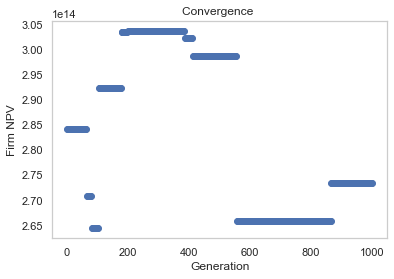

In [27]:
plt.scatter(my_data_frame_best['firm3']["generation"], my_data_frame_best['firm3']["payoff firm3"])
plt.title("Convergence " )
plt.ylabel('Firm NPV')
plt.xlabel('Generation')
plt.show()

In [28]:
my_data_frame_best['firm1'].sort_values(by ='payoff firm1', ascending=False )

,level_0,level_1,chromocombo,payoff,payoff firm1,chromo1,payoff firm2,chromo2,payoff firm3,chromo3,generation
71354,generation547,chromo194,"[12.858002770178695, [[13.144143219875096]], [...","[713810069129333.0, 428277579261143.0, 2855147...",7.138101e+14,12.858003,4.282776e+14,[[13.144143219875096]],2.855147e+14,[[12.0]],547
62384,generation478,chromo194,"[12.858002770178695, [[13.144143219875096]], [...","[713810069129333.0, 428277579261143.0, 2855147...",7.138101e+14,12.858003,4.282776e+14,[[13.144143219875096]],2.855147e+14,[[12.0]],478
58874,generation451,chromo194,"[12.858002770178695, [[13.144143219875096]], [...","[713810069129333.0, 428277579261143.0, 2855147...",7.138101e+14,12.858003,4.282776e+14,[[13.144143219875096]],2.855147e+14,[[12.0]],451
59264,generation454,chromo194,"[12.858002770178695, [[13.144143219875096]], [...","[713810069129333.0, 428277579261143.0, 2855147...",7.138101e+14,12.858003,4.282776e+14,[[13.144143219875096]],2.855147e+14,[[12.0]],454
59654,generation457,chromo194,"[12.858002770178695, [[13.144143219875096]], [...","[713810069129333.0, 428277579261143.0, 2855147...",7.138101e+14,12.858003,4.282776e+14,[[13.144143219875096]],2.855147e+14,[[12.0]],457
...,...,...,...,...,...,...,...,...,...,...,...
23090,generation178,chromo40,"[12.903931783616482, [[14.415034926090804]], [...","[639408975670092.8, 383635636704905.4, 2557536...",6.394090e+14,12.903932,3.836356e+14,[[14.415034926090804]],2.557537e+14,[[13.134060516969745]],178
22700,generation175,chromo40,"[12.903931783616482, [[14.415034926090804]], [...","[639408975670092.8, 383635636704905.4, 2557536...",6.394090e+14,12.903932,3.836356e+14,[[14.415034926090804]],2.557537e+14,[[13.134060516969745]],175
9340,generation70,chromo190,"[14.052321320769792, [[13.140928069932015]], [...","[632681522077825.1, 379601658715569.0, 2530638...",6.326815e+14,14.052321,3.796017e+14,[[13.140928069932015]],2.530639e+14,[[12.399103369880988]],70
9730,generation73,chromo190,"[14.052321320769792, [[13.140928069932015]], [...","[632681522077825.1, 379601658715569.0, 2530638...",6.326815e+14,14.052321,3.796017e+14,[[13.140928069932015]],2.530639e+14,[[12.399103369880988]],73


In [29]:
(my_data_frame_best['firm1']).to_csv("population_evolution_1_1000_firm1.csv", index=False)

In [30]:
(my_data_frame_best['firm2']).to_csv("population_evolution_2_1000_firm1.csv", index=False)

In [31]:
(my_data_frame_best['firm3']).to_csv("population_evolution_3_1000_firm1.csv", index=False)

In [32]:
my_data_frame_best

{'firm1':                level_0     level_1  \
 317        generation1   chromo167   
 1487      generation10   chromo167   
 12950    generation100    chromo40   
 130151  generation1000  chromo1411   
 13340    generation103    chromo40   
 ...                ...         ...   
 128201   generation985  chromo1411   
 128591   generation988  chromo1411   
 128981   generation991  chromo1411   
 129371   generation994  chromo1411   
 129761   generation997  chromo1411   
 
                                               chromocombo  \
 317     [13.860409539388323, [[12.104038276983658]], [...   
 1487    [13.860409539388323, [[12.104038276983658]], [...   
 12950   [12.903931783616482, [[14.415034926090804]], [...   
 130151  [13.260352509495192, [[12.0]], [[13.4203877673...   
 13340   [12.903931783616482, [[14.415034926090804]], [...   
 ...                                                   ...   
 128201  [13.260352509495192, [[12.0]], [[13.4203877673...   
 128591  [13.260352509495

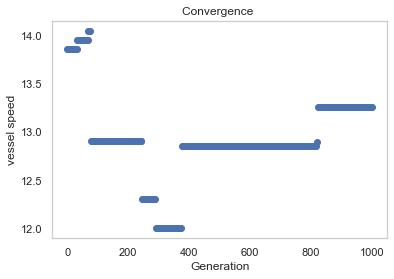

In [33]:
chromo_x = [(my_data_frame_best['firm1']['generation'].values[_],
             my_data_frame_best['firm1']["chromo1"].values[_] ) for _ in range(len(my_data_frame_best["firm1"]))]#[0]

x_val = [x[0] for x in chromo_x]
y_val = [x[1] for x in chromo_x]

plt.scatter(x_val,y_val )
plt.title("Convergence " )
plt.ylabel('vessel speed')
plt.xlabel('Generation')
plt.show()

# 2) Bidding procedure for deriving agreement among players with multiple alternative solutions from the CoGA.

### Selection of one integrated solution; How to derive an agreement among the players ?
 

Bid procedure to provide a 1 integrated solution between the players

After applying the CoGA, each player obtains a set of its chromosomes in its population, each of which has a fitness value and partners collected from the other population during the fitness evaluation of the corresponding chromosome. 


The final agreement should satisfy each player as much as possible. 

In the bidding process, 
- each player submits one solution in each round until all the players agree with the same solution among all the solutions submitted thus far.

The solution satisfies the following two conditions:
1. It is one of the Pareto optimal solutions among all the solutions the players have.
2. When the bidding process is applied, no other solution gives a higher profit to each player than the agreed solution

To satisfy the above two conditions;
- the dominated (looser chromo) solutions are removed from the solutions in the population of each player resulting from CoGA. 
- This step will provide the Pareto optimal solutions for each population. 
- The solutions remaining at the population of each player are ordered in decreasing order of payoff to the corresponding player.

In [34]:
def pareto_agrement(integrated_solution):
    coev_dataframe = pd.DataFrame.from_dict({(j,i): integrated_solution[i][j] 
                                             for i in integrated_solution.keys() 
                                             for j in integrated_solution[i].keys()},
                                            orient='index')

    #drop duplicates
    coev_dataframe = coev_dataframe.loc[coev_dataframe.astype(str).drop_duplicates().index]
    #print(coev_dataframe)
    #sort
    coev_dataframe = coev_dataframe.sort_values(by = 'payoff')
    #reindex
    coev_dataframe.reset_index(drop=True, inplace = True)
    #get payoff array
    payoff = np.array(coev_dataframe["payoff"])
    #get payoff length
    n_payoff = payoff.shape
    #initilise results 
    is_efficient = np.arange(len(payoff))
    next_point_index = 0  # Next index in the is_efficient array to search for

    while next_point_index < len(payoff):
        this_payoff = payoff[next_point_index]
        #print("this_payoff", this_payoff)

        # Two points `a` and `b` are *incomparable* if neither dom(a, b) nor dom(b, a).
        # Points that are incomparable to `this_cost`, or dominate `this_cost`.
         # In 2D, these points are below or to the left of `this_cost`.
        current_efficient_points = ([np.all(np.greater_equal(payoff[_], this_payoff)) for _ in range(len(payoff))])

        # Any point is incomparable to itself, so keep this point
        current_efficient_points[next_point_index] = True
        #print("current_efficient_points", current_efficient_points)

        # Remove dominated points
        is_efficient = is_efficient[current_efficient_points]
        #print("is_efficient", is_efficient)

        #Update candidate list 
        payoff = payoff[current_efficient_points]
        #print("payoff", payoff)

        # Re-adjust the index
        #print("current_efficient_points[:next_point_index]",current_efficient_points[:next_point_index])
        next_point_index = int(np.sum(current_efficient_points[:next_point_index]) + 1)
        #print('next_point_index', next_point_index)
        #print("======")

    
#     is_efficient_mask = np.zeros(n_payoff, dtype=np.bool_)
#     is_efficient_mask[is_efficient] = True
#     is_efficient_mask
    inegrated_solution_chromo = np.vstack(coev_dataframe["chromocombo"][int(is_efficient)])
    inegrated_solution_payoff = coev_dataframe["payoff"][int(is_efficient)]
    return coev_dataframe,is_efficient, inegrated_solution_chromo, inegrated_solution_payoff


In [35]:
coev_dataframe,is_efficient, inegrated_solution_chromo, inegrated_solution_payoff = pareto_agrement(integrated_solution)
print("best chromo", inegrated_solution_chromo)
print("pareto payoff", inegrated_solution_payoff)
is_efficient
#coev_dataframe



best chromo [[13.26035251]
 [12.        ]
 [13.42038777]]
pareto payoff [699928013411536.2, 419949804999109.3, 279961355906411.56]


array([1169])

# 3) Local search procedure and Hill climbing

In [36]:
def in_bounds(point, bounds ):
    # enumerate all dimensions of the point
    """get a chromo and return wether or not in the right range"""
    check_min = np.all([point[_] >= bounds[0] for _ in range(len(point))])
    #print("check_min", check_min)
    check_max = np.all([point[_] <= bounds[1] for _ in range(len(point))])
    #print("check_max", check_max)
    check_chromo = np.all(check_max) and  np.all(check_min)
    #print("check_chromo", check_chromo)
    return check_chromo

In [37]:
def rebound_chromo(chromo, firm):
    #for i in range(len(chromo)):
    chromo= firm.min_speed if (chromo < firm.min_speed) else chromo
    chromo= firm.max_speed if (chromo > firm.max_speed) else chromo
    return chromo

In [38]:
# hill climbing local search algorithm
def hillclimbing(fitness, bounds, n_iterations, step_size, start_pt):
    # store the initial point
    solution = start_pt
    # evaluate the initial point
    solution_eval = fitness( vessel_proc = partial(vessel_operation_procedure,
                          sim_game = game_config ),  
                        chromo_array = solution,
                        sim_game = game_config ,
                        carbon_pollution_decay_parameter = 1,
                        sulfur_pollution_decay_parameter=1,
                        carbon_pollution_damage_parameter=1.5,
                        sulfur_pollution_damage_parameter=1.5,
                        initial_carbon_tax_sim =0,
                        initial_sulfur_tax_sim =0,
                        taxation_scheme_rate_sim=0)[0]
    
    # run the hill climb
    for i in range(n_iterations):
        # take a step
        candidate = np.array([solution[firm] + np.random.randn(1) * step_size for firm in range(len(Firm._registry))])
        in_boundary = ([in_bounds(candidate[_], bounds[_])  for _  in range(len(Firm._registry))])

        while np.any(np.logical_not(in_boundary)): 
            is_in_boundary = np.arange(len(Firm._registry))
            is_in_boundary_index = is_in_boundary[np.logical_not(in_boundary)]

            for index in range(len(is_in_boundary_index)):
                bad_chromo_index = is_in_boundary_index[index]
                bad_firm = Firm._registry[bad_chromo_index]
                bad_chromo = candidate[bad_chromo_index]
                candidate[bad_chromo_index] = rebound_chromo(bad_chromo, bad_firm)
            
            in_boundary = ([in_bounds(candidate[_], bounds[_])  for _  in range(len(Firm._registry))])
       
        # evaluate candidate point
        candidate_eval = fitness( vessel_proc = partial(vessel_operation_procedure,
                          sim_game = game_config ),  
                        chromo_array = candidate,
                        sim_game = game_config ,
                        carbon_pollution_decay_parameter = 1,
                        sulfur_pollution_decay_parameter=1,
                        carbon_pollution_damage_parameter=1.5,
                        sulfur_pollution_damage_parameter=1.5,
                        initial_carbon_tax_sim =0,
                        initial_sulfur_tax_sim =0,
                        taxation_scheme_rate_sim=0)[0]
        # check if we should keep the new point
        if (np.greater_equal(candidate_eval, solution_eval)).all():        
            # store the new point
            solution, solution_eval = candidate, candidate_eval
    return [solution, solution_eval]

In [39]:
# iterated local search algorithm
def iterated_local_search(fitness, bounds, n_iter, step_size, n_restarts, p_size):
    # iterated local search algorithm
    #initlise Best chromo and best eval from Coev previous results 
    best_chromo = inegrated_solution_chromo #inegrated_solution_chromo
    
    # evaluate current best point
    best_eval = fitness( vessel_proc = partial(vessel_operation_procedure,
                                               sim_game = game_config ),  
                        chromo_array = best_chromo,
                        sim_game = game_config ,
                        carbon_pollution_decay_parameter = 1,
                        sulfur_pollution_decay_parameter=1,
                        carbon_pollution_damage_parameter=1.5,
                        sulfur_pollution_damage_parameter=1.5,
                        initial_carbon_tax_sim =0,
                        initial_sulfur_tax_sim =0,
                        taxation_scheme_rate_sim=0)[0]


    # enumerate restarts
    for n in range(n_restarts):
        # generate an initial point as a perturbed version of the last best
        start_pt = np.array([best_chromo[firm] + np.random.randn() * p_size for firm in range(len(Firm._registry))])
       
        in_boundary = ([in_bounds(start_pt[_], bounds[_])  for _  in range(len(Firm._registry))])
        #get index of the chromo to reupdate 

        while np.any(np.logical_not(in_boundary)): 
            is_in_boundary = np.arange(len(Firm._registry))
            is_in_boundary_index = is_in_boundary[np.logical_not(in_boundary)]
            
            #Boundary Update
            for index in range(len(is_in_boundary_index)):
                bad_chromo_index = is_in_boundary_index[index]
                bad_firm = Firm._registry[bad_chromo_index]
                bad_chromo = start_pt[bad_chromo_index]
                start_pt[bad_chromo_index] = rebound_chromo(bad_chromo, bad_firm)
            in_boundary = ([in_bounds(start_pt[_], bounds[_])  for _  in range(len(Firm._registry))])


        # perform a stochastic hill climbing search
        solution, solution_eval = hillclimbing(fitness, bounds, n_iter, step_size, start_pt)

        # check for new best
        if (np.greater_equal(solution_eval, best_eval)).all():
            best, best_eval = solution, solution_eval


    return [best, best_eval]

In [40]:
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = [asarray([myfirm.min_speed , myfirm.max_speed ]) for myfirm in Firm._registry ]

# define the total iterations
n_iter = 100
# define the maximum step size
s_size = 0.05
# total number of random restarts
n_restarts = 50
# perturbation step size
p_size = 1.0
# perform the hill climbing search
my_best, score = iterated_local_search(fitness, bounds, n_iter, s_size, n_restarts, p_size)
print('Done!')
#print('f(%s) = %f' % (best, score))

Done!


In [41]:
my_best

array([[12.],
       [12.],
       [12.]])

In [69]:
(score)

[793231160655763.4, 475930517599824.44, 317282634237542.1]

### Results

In [70]:
best_payoff, best_discounted_period_profit, best_period_profit, best_policy_cost, best_sulfur_policy_cost, best_carbon_policy_cost, best_industry_sulfur_damages, best_industry_carbon_damages, best_sulfur_emissions, best_carbon_emissions, best_industry_carbon_emission, best_industry_sulfur_emission, best_carbon_pollution_stock, best_sulfur_pollution_stock, best_carbon_dynamic_tax, best_sulfur_dynamic_tax, best_operations = fitness( vessel_proc = partial(vessel_operation_procedure,
                                               sim_game = game_config ),  
                        chromo_array = my_best,
                        sim_game = game_config ,
                        carbon_pollution_decay_parameter = 1,
                        sulfur_pollution_decay_parameter=1,
                        carbon_pollution_damage_parameter=1.5,
                        sulfur_pollution_damage_parameter=1.5,
                        initial_carbon_tax_sim =0,
                        initial_sulfur_tax_sim =0,
                        taxation_scheme_rate_sim=0)
#operations

In [77]:
np.sum(best_carbon_emissions[0]) + np.sum(best_carbon_emissions[1])  + np.sum(best_carbon_emissions[2])

183907571.41806573

In [80]:
183907571.41806573 - 189273208.0949269

-5365636.676861167

# Analysis

## c. Compute emissions throughout the planning horizon


In [46]:
best_discounted_period_profit_df = pd.DataFrame(columns = firms, index = periodes ) # 
for periode in periodes:
    for firm in  Firm._registry:
        best_discounted_period_profit_df["firm"+str(firm.index)][periode] = best_discounted_period_profit[firm.index-1][periode]
best_discounted_period_profit_df

,firm1,firm2,firm3
0,28079684154431.613281,16847519246719.419922,11231525916595.398438
1,19830313038614.171875,11897898008015.244141,7931775479253.847656
2,18903765208239.71875,11341974992440.634766,7561163204676.455078
3,23393165968627.335938,14035588868128.193359,9356897027534.087891
4,24035966871585.746094,14421265592530.791016,9614005729165.105469
5,24604103058905.054688,14762145314713.021484,9841265333122.376953
6,25413634559114.582031,15247852890969.583984,10165065346495.910156
7,26301066838365.960938,15780323398581.865234,10520043624395.447266
8,27170947669186.894531,16302251250963.775391,10867990948842.544922
9,28002019657919.132812,16800893130519.232422,11200424557648.046875


In [45]:
firms = ["firm" + str(index.index) for index in Firm._registry] #optimum_solution[1].keys()
periodes = range(MarketConfig.T) #optimum_solution.keys()

##### Discounted Period Profits

In [47]:
best_discounted_period_profit_df.to_csv("discounted_period_profit_1_1000.csv", index=False)

#####  Vessel Speed

In [48]:
Vessel_speed_optimum_best_df = pd.DataFrame(columns = firms)
for firm in  Firm._registry:
    Vessel_speed_optimum_best_df["firm"+str(firm.index)] = my_best[firm.index-1]
Vessel_speed_optimum_best_df

,firm1,firm2,firm3
0,12.0,12.0,12.0


In [49]:
Vessel_speed_optimum_best_df.to_csv("vessel_speed_1_1000.csv", index=False)

#####  Number of vessels

In [50]:
number_of_vessel_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in Firm._registry:
        number_of_vessel_optimum["firm"+str(firm.index)][periode] = best_operations[firm.index-1][0][periode] #0 is for #of vessels
number_of_vessel_optimum

,firm1,firm2,firm3
0,84.0,88.0,78.0
1,86.0,90.0,80.0
2,86.0,90.0,80.0
3,93.0,98.0,87.0
4,97.0,102.0,91.0
5,100.0,105.0,93.0
6,102.0,108.0,96.0
7,105.0,110.0,98.0
8,108.0,113.0,101.0
9,111.0,116.0,103.0


In [51]:
number_of_vessel_optimum.to_csv("number_of_vessel_1_1000.csv", index=False)

#####  Carbon Emissions Path

In [52]:
carbon_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in Firm._registry:
        carbon_emission["firm"+str(firm.index)][periode]= best_carbon_emissions[firm.index-1][periode]


carbon_emission

,firm1,firm2,firm3
0,2477618.823083,1535349.204069,1069230.20105
1,2556902.625421,1576214.011782,1096646.360052
2,2556902.625421,1576214.011782,1096646.360052
3,2765022.60656,1710484.094267,1188033.556723
4,2874037.834776,1774700.220673,1238296.514892
5,2953321.637115,1827240.687733,1270282.033726
6,3032605.439453,1879781.154792,1306836.912395
7,3111889.241792,1926483.792178,1338822.43123
8,3201083.519423,1979024.259238,1375377.309898
9,3280367.321761,2031564.726297,1411932.188566


In [53]:
carbon_emission.to_csv("carbon_emission_1_1000.csv", index=False)

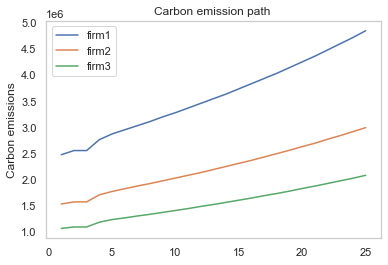

In [54]:
plt.plot(list(range(1,MarketConfig.T+1)),carbon_emission)
plt.title("Carbon emission path " )
plt.ylabel('Carbon emissions')
plt.legend(labels  =carbon_emission.columns.tolist())
plt.show()


### Sulfur Emission Path


In [55]:
sulfur_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in Firm._registry:
        sulfur_emission["firm"+str(firm.index)][periode]= best_sulfur_emissions[firm.index-1][periode]


sulfur_emission

,firm1,firm2,firm3
0,6869.402027,4208.282912,2733.383483
1,7089.222892,4320.290442,2803.470238
2,7089.222892,4320.290442,2803.470238
3,7666.252662,4688.315184,3037.092758
4,7968.506351,4864.327016,3165.585144
5,8188.327216,5008.336698,3247.353026
6,8408.148081,5152.346379,3340.802034
7,8627.968945,5280.354985,3422.569916
8,8875.267418,5424.364666,3516.018924
9,9095.088283,5568.374348,3609.467932


In [56]:
sulfur_emission.to_csv("sulfur_emission_1_1000.csv", index=False)

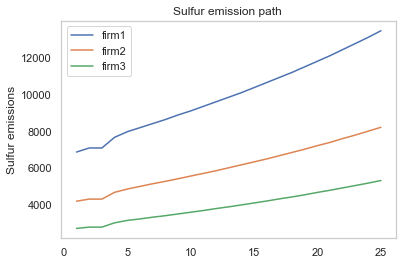

In [57]:
plt.plot(list(range(1,MarketConfig.T+1)),sulfur_emission)
plt.title("Sulfur emission path " )
plt.ylabel('Sulfur emissions')
plt.legend(labels  = sulfur_emission.columns.tolist())
plt.show()


# Population evolution

#####  Carbon and Sulfur Pollution Stock

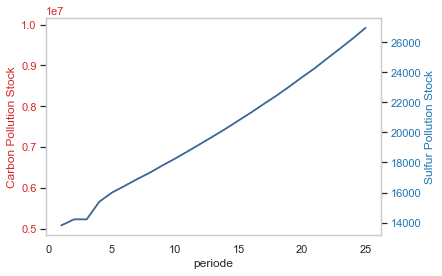

,Carbon Pollution Stock,Sulfur Pollution Stock
0,5082198.228202,13811.068421
1,5229762.997255,14212.983572
2,5229762.997255,14212.983572
3,5663540.25755,15391.660604
4,5887034.570341,15998.418512
5,6050844.358574,16444.01694
6,6219223.50664,16901.296494
7,6377195.4652,17330.893847
8,6555485.088558,17815.651009
9,6723864.236625,18272.930563


In [58]:
Pollution_Stock = pd.DataFrame(columns = ["Carbon Pollution Stock", "Sulfur Pollution Stock"] ,  index = periodes )

for periode in periodes:
    Pollution_Stock["Carbon Pollution Stock"][periode] = best_industry_carbon_emission[periode]
    Pollution_Stock["Sulfur Pollution Stock"][periode] = best_industry_sulfur_emission[periode]

# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel('Carbon Pollution Stock', color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Carbon Pollution Stock"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sulfur Pollution Stock', color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Sulfur Pollution Stock"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Pollution_Stock

In [59]:
Pollution_Stock.to_csv("Pollution_Stock_1_1000.csv", index=False)

#####  Carbon and Sulfur Pollution Damages

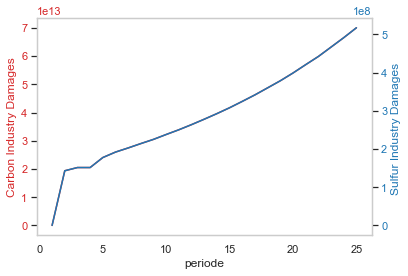

,Carbon Industry Damages,Sulfur Industry Damages
0,0.0,0.0
1,19371554123056.253906,143059208.205963
2,20512815755593.3125,151506676.518232
3,20512815755593.3125,151506676.518232
4,24056766186667.703125,177677412.104895
5,25992882024289.640625,191962046.155355
6,27459538088761.109375,202804269.838888
7,29009055769157.601562,214240367.385438
8,30501466501021.910156,225269911.14102
9,32230788559733.46875,238048065.653054


In [60]:
Industry_Damages = pd.DataFrame(columns = ["Carbon Industry Damages", "Sulfur Industry Damages "] ,  index = periodes )

for periode in periodes:
    Industry_Damages["Carbon Industry Damages"][periode] = best_industry_carbon_damages[periode]
    Industry_Damages["Sulfur Industry Damages "][periode] = best_industry_sulfur_damages[periode]

    
    
# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel("Carbon Industry Damages", color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Carbon Industry Damages"] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Sulfur Industry Damages ", color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Sulfur Industry Damages "] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Industry_Damages

In [61]:
Industry_Damages.to_csv("Industry_Damages_1_1000.csv", index=False)

# Output Results

- Net present value
- Total Fixed Cost(USD)
- Total Fuel Consumption 
- Cost(USD)


- Average fleet size 
- Average vessel speed


- BAUCO2emissions
- BAUCO2pollution stock
- BAUCO2 environmental damages


- BAUSOx emissions
- BAUSOx pollution stock
- BAUSOx environmental damage